In [1]:
import numpy as np
import pandas as pd
import hist
from hist import Hist
import awkward as ak
import json
import uproot

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

In [6]:
json_dir = "inputfiles/2022/Hbb"
out_dir = "outfiles"

# Samples

* [BulkGraviton](#bulk)
* [ggF](#ggf)
* [QCD](#qcd)

# BulkGraviton <a class="anchor" id="bulk"></a>

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

In [19]:
def load_files(filepaths, treename='Events', filter_name=None, selection=None):
    import glob
    dfs = []
    if not isinstance(filepaths, (list, tuple)):
        filepaths = [filepaths]
#     filepaths = sum([glob.glob(fp) for fp in filepaths], [])
#     print(filepaths)
    for fp in filepaths:
        df = uproot.open(fp)[treename].arrays(library='pd', filter_name=filter_name)
        if selection is not None:
            df = df.query(selection)
        dfs.append(df)
    return pd.concat(dfs)

In [20]:
def bkg_rej(tpr, fpr, eff=0.5):
    idx = next(idx for idx, v in enumerate(tpr) if v>eff)
#     print('tpr=%.3f, fpr=%.6f, 1/fpr=%.2f'%(tpr[idx], fpr[idx], 1/fpr[idx]))
    rej = 1/fpr[idx]
    return rej

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [21]:
def plot(comp_list, comp_text='', eff_wps=[0.4,0.6,0.8]):

    debug = False
    sortLegend = False
    
    colours = ["#FF66FF","#FF9900","deepskyblue"]
    i_c = 0
    
    aucs = {}
    idx = 0
    f, ax = plt.subplots(figsize=(10,10))
    for name, cfg in comp_list.items():
        if debug: print(name)
        if debug: print(cfg)
        bkgrejs = {}
        sig, bkg = cfg['label']
        sel = f"{cfg.get('selection')} & ({sig}==1 | {bkg}==1)"
        df = load_files(cfg['filepath'], treename=cfg.get('treename', 'Events'), 
                        filter_name=cfg.get('filter_name'), selection=sel)
        if debug: print(name, cfg['score'], sel, len(df), sep=",")

        score = cfg['score']
        y_true = df[sig]
        y_pred = df.eval(score)

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        aucs[idx] = auc
        idx += 1
        
        ax.plot(tpr, fpr, label='%s (AUC = %.4f)'%(name, auc), color="gray", linewidth=2)
        
        for wp in eff_wps:
            tpr_idx = find_nearest(tpr, wp)
            tpr_p = tpr[tpr_idx]
            fpr_p = fpr[tpr_idx]
            ax.plot(tpr_p, fpr_p, marker='o', color=colours[i_c], label=r"$\epsilon_{S} = $" + f"{tpr_p*100:.0f}%, " r"$\epsilon_{B} = $" + f"{fpr_p*100:.1f}%", linestyle='', markersize=12)
            print(f"{tpr_p, fpr_p, thresholds[tpr_idx]}")
            i_c += 1

        for wp in eff_wps:
            bkgrejs[wp] = bkg_rej(tpr, fpr, wp)

        if debug: print(' - ', name, auc, [bkgrejs[wp] for wp in eff_wps], sep=',')
        
    if sortLegend:
        order = dict(sorted(aucs.items(), key=lambda item: item[1])).keys()
        handels, labels = plt.gca().get_legend_handles_labels()
        ax.legend([handels[idx] for idx in order],[labels[idx] for idx in order], loc='best', fontsize=16)
        
#     ax.legend(bbox_to_anchor=(1.04,1), loc="best")
    ax.legend(loc="lower right", fontsize=20)
    ax.set_yscale('log')
    ax.set_ylim(1e-5 if auc > 0.999 else 1e-4, 1)
    ax.set_xlim(0.9 if auc > 0.999 else 0, 1)
    ax.set_xlabel(r'Signal efficiency ($\epsilon_{S}$)', horizontalalignment='right', x=1.0)
    ax.set_ylabel(r'Background efficiency ($\epsilon_{B}$)', horizontalalignment='right', y=1.0)
    ax.text(0.05, 0.88, comp_text, transform=ax.transAxes, fontsize=20) #, weight='bold')
    label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")
    
    return df

(0.40000004197983624, 0.0015896484440823765, 0.9864132)
(0.5999999580201637, 0.00606588230645598, 0.95448214)
(0.7999994542621288, 0.02391663344912021, 0.8167194)


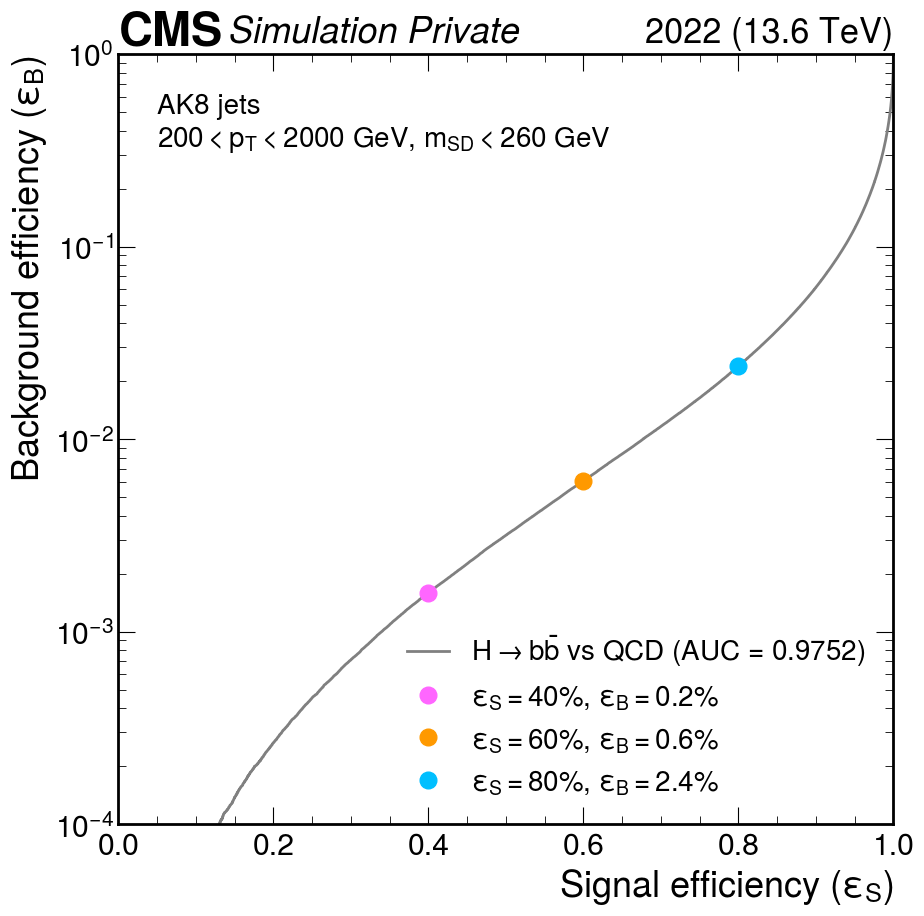

In [24]:
sigs = ["H_bb"] #, "H_cc", "H_qq", "H_tautau"]

labels = {
    "H_bb" : r'$H\rightarrow b\bar{b}$ vs QCD',
    "H_cc" : r'$H\rightarrow c\bar{c}$ vs QCD',
}

algos = {}

for sig in sigs:
    
    decay = sig.split("_", 1)[-1]
    if "tau" in decay:
        decay = r"$\tau\tau$"
    label = f'H({decay})'
    
    algos[labels[sig]] = {
#         'filepath' : "root://eosuser.cern.ch//eos/user/p/pinkaew/Run3ScoutingTaggingOutput/ak8_flavour_20231031-181958_flavour_ranger_lr0.01_batch512_orig/predict_output/pred.root",
        'filepath' : "root://eoscms.cern.ch//eos/cms/store/group/ml/Tagging4ScoutingHackathon/Adelina/hbb/20epoch/flavour/pred.root",
        'label' : [f'label_{sig}', 'label_QCD_all'],
        'score' : f'score_label_{sig}/(score_label_{sig} + score_label_QCD_all)',
        'selection' : '(fj_msd<260) & (fj_pt>200) & (fj_pt<2500) & ((sample_isQCD==0 & label_QCD_all==0) | (sample_isQCD==1 & label_QCD_all==1))'
    }    
    
df = plot(algos, comp_text="AK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV")

In [35]:
df

,label_QCD_all,score_label_QCD_all,label_H_bb,score_label_H_bb,label_H_cc,score_label_H_cc,label_H_qq,score_label_H_qq,label_H_tautau,score_label_H_tautau,...,fj_pt,fj_mass,fj_n2b1,fj_eta,fj_phi,fj_msd,fj_npfcands,fj_genjet_sdmass,fj_gen_mass,sample_isQCD
0,0,0.162348,0,0.021383,0,0.153374,1,0.662070,0,0.000826,...,507.000,133.25000,0.264404,-0.783691,-0.053040,129.750000,57,126.887474,116.858559,0
1,0,0.019532,1,0.781028,0,0.196072,0,0.002871,0,0.000497,...,641.000,152.12500,0.386963,1.644531,2.767578,77.062500,47,77.519913,75.222954,0
2,0,0.054759,1,0.928225,0,0.015480,0,0.001020,0,0.000515,...,474.750,153.75000,0.365723,1.520508,-0.433350,148.125000,72,163.901016,140.519775,0
3,0,0.002931,1,0.956653,0,0.038751,0,0.001659,0,0.000007,...,455.750,107.37500,0.284180,0.328857,-0.123535,84.187500,45,109.000381,109.012199,0
4,0,0.305432,0,0.037955,0,0.304099,1,0.352148,0,0.000366,...,535.000,119.81250,0.312256,0.020264,-2.214844,94.437500,36,101.775368,95.240784,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22176742,1,0.090161,0,0.009017,0,0.022930,0,0.001353,0,0.876540,...,361.750,157.62500,0.311279,-0.411621,-0.402100,157.625000,62,-99.000000,0.000000,1
22176743,1,0.523364,0,0.018287,0,0.131773,0,0.326363,0,0.000214,...,277.250,53.62500,0.442627,0.909668,2.482422,5.593750,36,-99.000000,0.000000,1
22176744,1,0.394444,0,0.012464,0,0.213212,0,0.378286,0,0.001594,...,851.500,164.25000,0.307617,0.064392,-1.617188,4.175781,55,10.147821,0.000000,1
22176745,1,0.823887,0,0.010943,0,0.057785,0,0.106553,0,0.000832,...,806.000,131.87500,0.437012,-1.752930,1.459961,7.160156,42,17.948519,0.000000,1


/tmp/ipykernel_103/3436880798.py:34: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1)


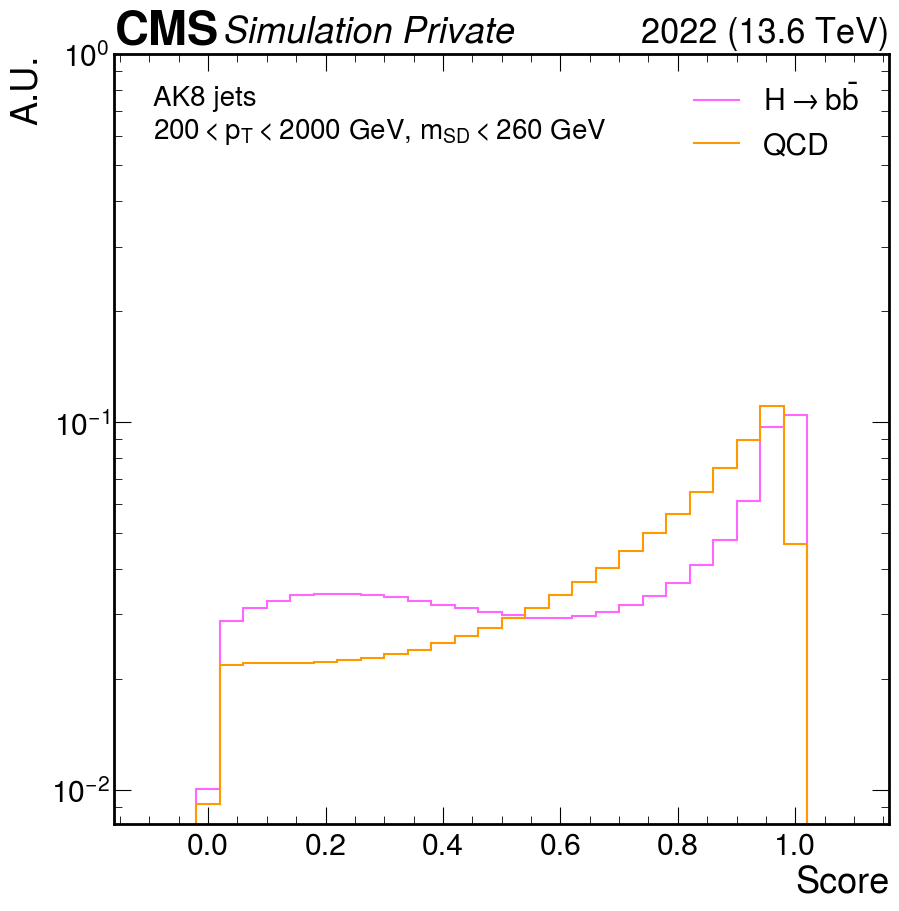

In [13]:
fig, ax = plt.subplots(figsize=(10,10))

colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
    "hcc" : "deepskyblue"
}

labels = {
    "hbb" : r"$H\rightarrow b\bar{b}$",
    "qcd" : "QCD",
    "hcc" : r"$H\rightarrow c\bar{c}$",
}

for label, events in [("hbb", "H_bb"), ("qcd", "QCD_all")]:

    score = df.loc[df[f'label_{events}' if label != "qcd" else "sample_isQCD"] == 1, f'score_label_{events}'].values

    h = Hist(
        hist.axis.Regular(30, -0.1, 1.1, name="score", label=r"Score"),
    )

    h.fill(
        score = score
    )

    n = h.sum()
    h = h / n

    mplhep.histplot(h, ax=ax, label=labels[label], color=colours[label])
   

ax.set_yscale('log')
ax.set_ylim(0, 1)
ax.legend(loc="upper right")
ax.set_xlabel("Score")
ax.set_ylabel("A.U.")
label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.88, "AK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
#                   weight='bold'
                 )

/tmp/ipykernel_103/2923824250.py:37: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 2)


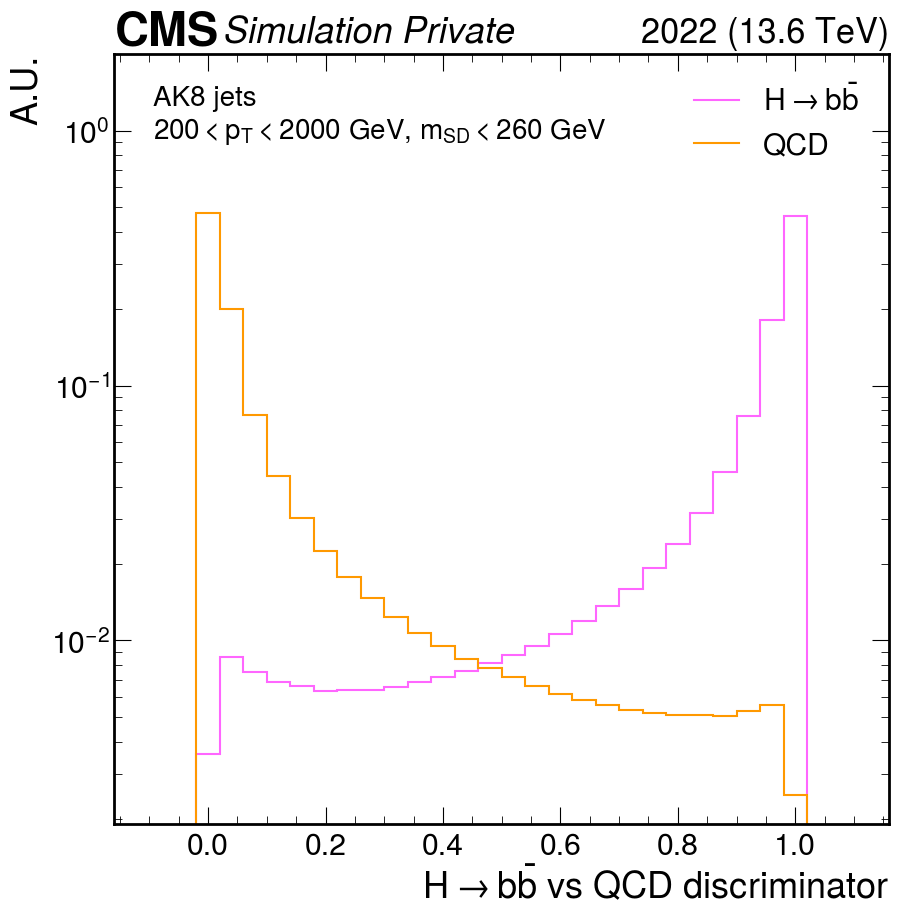

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
    "hcc" : "deepskyblue"
}

labels = {
    "hbb" : r"$H\rightarrow b\bar{b}$",
    "qcd" : "QCD",
    "hcc" : r"$H\rightarrow c\bar{c}$",
}

for label, events in [("hbb", "H_bb"), ("qcd", "QCD_all")]:

    score_sig = df.loc[df[f'label_{events}' if label != "qcd" else "sample_isQCD"] == 1, 'score_label_H_bb'].values
    score_bkg = df.loc[df[f'label_{events}' if label != "qcd" else "sample_isQCD"] == 1, 'score_label_QCD_all'].values

    disc = (score_sig) / (score_sig + score_bkg)

    h = Hist(
        hist.axis.Regular(30, -0.1, 1.1, name="disc", label=r"$H\rightarrow b\bar{b}$ vs QCD discriminator"),
    )

    h.fill(
        disc = disc
    )

    n = h.sum()
    h = h / n

    mplhep.histplot(h, ax=ax, label=labels[label], color=colours[label])
   

ax.set_yscale('log')
ax.set_ylim(0, 2)
ax.legend(loc="upper right")
ax.set_xlabel(r"$H\rightarrow b\bar{b}$ vs QCD discriminator")
ax.set_ylabel("A.U.")
label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.88, "AK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
#                   weight='bold'
                 )

In [3]:
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema, ScoutingJMENanoAODSchema, BaseSchema
from coffea import processor, util
from collections import defaultdict

class Processor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, jets):
                
        dataset = jets.metadata['dataset']
        output = defaultdict()
        
        h = Hist(
            hist.axis.Variable([-0.1, 0.8167194, 0.95448214, 0.9864132, 1.1], name="disc", label=r"$H\rightarrow b\bar{b}$ vs QCD discriminator"),
            hist.axis.Regular(50, -3.2, 3.2, name="eta", label=r"$\eta$"),
            hist.axis.Regular(50, -3.5, 3.5, name="phi", label=r"$\phi$"),
#             hist.axis.Regular(50, 190, 1000, name="pt", label=r"$p_T$"),
            hist.axis.Regular(36, 200, 2000, name="pt", label=r"$p_T$"),
            hist.axis.StrCategory([], name="cat", label="Category", growth=True)
        )
        
        def normalise(arr):
            return ak.to_numpy(ak.fill_none(arr, np.nan))
        
        def hbb_disc(sig, bkg):
            return ak.where((sig + bkg == 0), 0, sig / (sig + bkg))
        
        jets = jets[
            (jets.fj_pt > 200) &
            (jets.fj_pt < 2000) &
            (jets.fj_msd < 260)
        ]
        
        cat = np.zeros(len(jets.fj_pt))
        cat = ["qcd" if qcd else c for c, qcd in zip(cat, jets.sample_isQCD.to_numpy())]
        cat = ["hbb" if hbb else c for c, hbb in zip(cat, jets.label_H_bb.to_numpy())]
        cat = ["hcc" if hcc else c for c, hcc in zip(cat, jets.label_H_cc.to_numpy())]
        cat = ["hqq" if hqq else c for c, hqq in zip(cat, jets.label_H_qq.to_numpy())]
        cat = ["htautau" if htautau else c for c, htautau in zip(cat, jets.label_H_tautau.to_numpy())]

        disc = hbb_disc(
            jets.score_label_H_bb,
            jets.score_label_QCD_all,
        )
        
        h.fill(
            disc = normalise(disc),
            eta = normalise(jets.fj_eta),
            phi = normalise(jets.fj_phi),
            pt = normalise(jets.fj_pt),
            cat = normalise(cat)
        )
        
        output["h"] = h

        return output

    def postprocess(self, accumulator):
        pass

In [ ]:
futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema=BaseSchema,
)

output = futures_run(
    {
        "pred" : ["root://eoscms.cern.ch//eos/cms/store/group/ml/Tagging4ScoutingHackathon/Adelina/hbb/20epoch/flavour/pred.root"],
    },
    "Events",
    processor_instance=Processor()
)

util.save(output, f"{out_dir}/tagger.coffea")

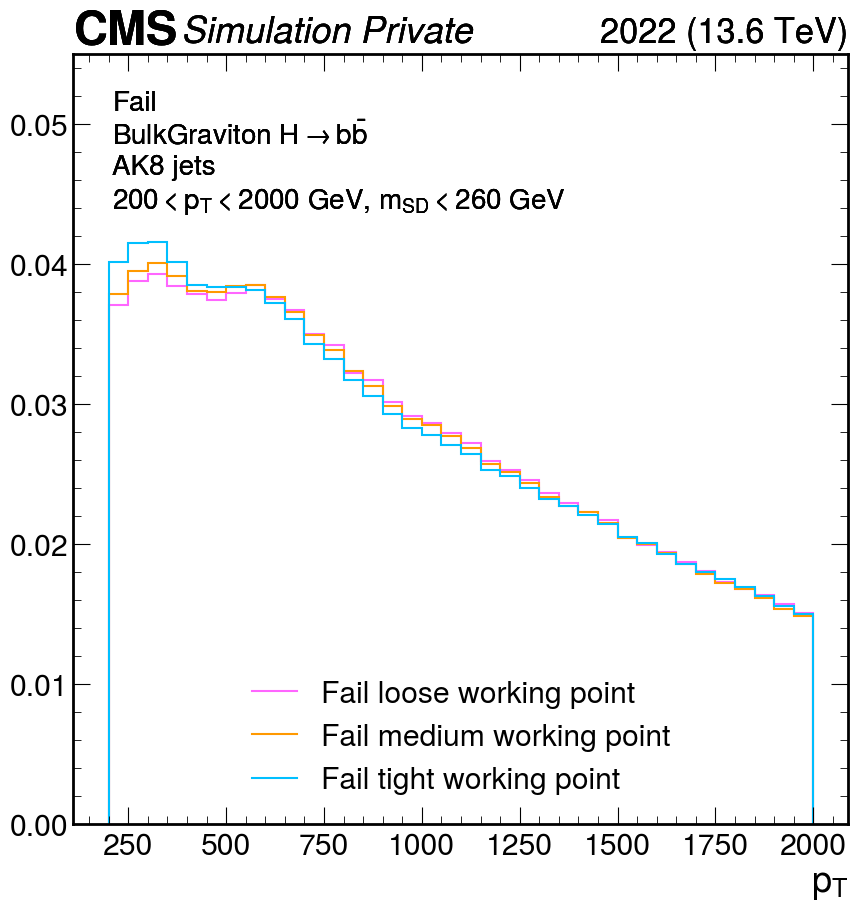

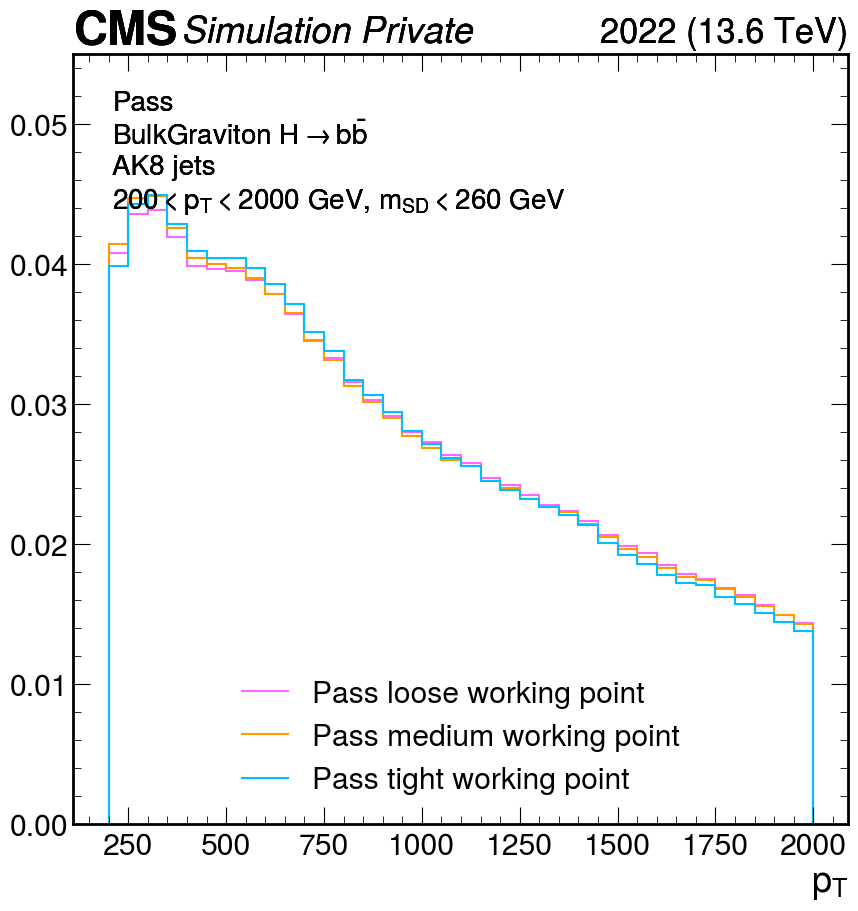

In [13]:
colours = {
    1 : "#FF66FF",
    2 : "#FF9900",
    3 : "deepskyblue",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 1

h = output["h"]

for events, match in [(f"Fail", 0), (f"Pass", 1)]:
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for wp in labels.keys():

        for var in ["pt"]:

            if "Pass" in events:
                h1 = h.project(var, "cat", "disc")[:, hist.loc("hbb"), wp:4:sum]
                h1 = h1 / h1.sum()
            else:
                h1 = h.project(var, "cat", "disc")[:, hist.loc("hbb"), 0:wp:sum]
                h1 = h1 / h1.sum()

            mplhep.histplot(
                h1,
                ax=ax,
                label=f"{events} {labels[wp]} working point",
                color=colours[wp],
           )


    #     ax.set_yscale('log')
    #     ax.set_xlabel(r"$m_{reco}$")
        ax.legend(loc="lower center")
    #     ax.legend(loc="lower center")
        if var == "eta":
            ax.set_ylim(0, 0.13)
            ax.set_xlim(-3.2, 4)
        elif var == "phi":
            ax.set_ylim(0, 0.06)
            ax.set_xlim(-3.9, 4)
        elif var == "pt":
            ax.set_ylim(0, 0.055)

        label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

        coffee = plt.text(0.05, 0.79, f"{events}\n" + r"BulkGraviton $H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                          fontsize=20,
                          horizontalalignment='left',
                          verticalalignment='bottom',
                          transform=ax.transAxes,
                         )
              
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

# ggF <a class="anchor" id="ggf"></a>

In [5]:
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema, ScoutingJMENanoAODSchema, BaseSchema
from coffea import processor, util
from collections import defaultdict

class Processor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        
        dataset = events.metadata['dataset']
        output = defaultdict()
        output["nevents"] = len(events)
        
        h = Hist(
            hist.axis.Regular(100, -0.1, 1.1, name="disc1", label=r"$H\rightarrow b\bar{b}$ vs QCD discriminator"),
            hist.axis.Variable([-0.1, 0.8167194, 0.95448214, 0.9864132, 1.1], name="disc2", label=r"$H\rightarrow b\bar{b}$ vs QCD discriminator"),
            hist.axis.Regular(30, -0.1, 200, name="msd", label=r"$m_{SD}$"),
            hist.axis.Regular(50, -0.1, 1.1, name="tau21", label=r"$\tau_1^2$"),
            hist.axis.Boolean(name="match"),
        )
        
        def normalise(arr):
            return ak.to_numpy(ak.fill_none(arr, np.nan))

        def hbb_disc(sig, bkg):
            return ak.where((sig + bkg == 0), 0, sig / (sig + bkg))
        
        fatjets = events.ScoutingFatJet
        fatjets = fatjets[
            (fatjets.pt > 200) &
            (fatjets.pt < 2000) &
            (fatjets.msoftdrop < 260)
        ]
        fatjet = ak.firsts(fatjets)

        # get Higgs
        H = events.GenPart[
            (abs(events.GenPart.pdgId) == 25)
            & (events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy']))
        ]

        # get b quarks
        b_H = ak.flatten(H.children)

        b_H_dr = fatjet.delta_r(b_H)
        index_descend_b_H = ak.argsort(b_H_dr, axis=1, ascending=False)
        b_H_dr_descend = b_H_dr[index_descend_b_H]

        # is fatjet matched to b quarks?
        is_fatjet_b_H = ak.firsts(b_H_dr_descend, axis=1) < 0.8
        
        disc = hbb_disc(
            fatjet.particleNet_prob_Hbb,
            fatjet.particleNet_prob_QCD
        )

        h.fill(
            disc1 = normalise(disc),
            disc2 = normalise(disc),
            msd = normalise(fatjet.msoftdrop),
            tau21 = normalise(fatjet["tau2"] / fatjet["tau1"]),
            match = normalise(is_fatjet_b_H),
        )
        
        output["h"] = h

        return output

    def postprocess(self, accumulator):
        pass

In [48]:
fileset = {}
with open(f"{json_dir}/GluGluHto2B.json") as fin:
    fileset = json.load(fin)

futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema=ScoutingNanoAODSchema,
)

output = futures_run(
    fileset,
    "Events",
    processor_instance=Processor()
)

util.save(output, "outfiles/2022/tagger/GluGluHto2B.coffea")

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


In [6]:
output = util.load("outfiles/2022/tagger/GluGluHto2B.coffea")

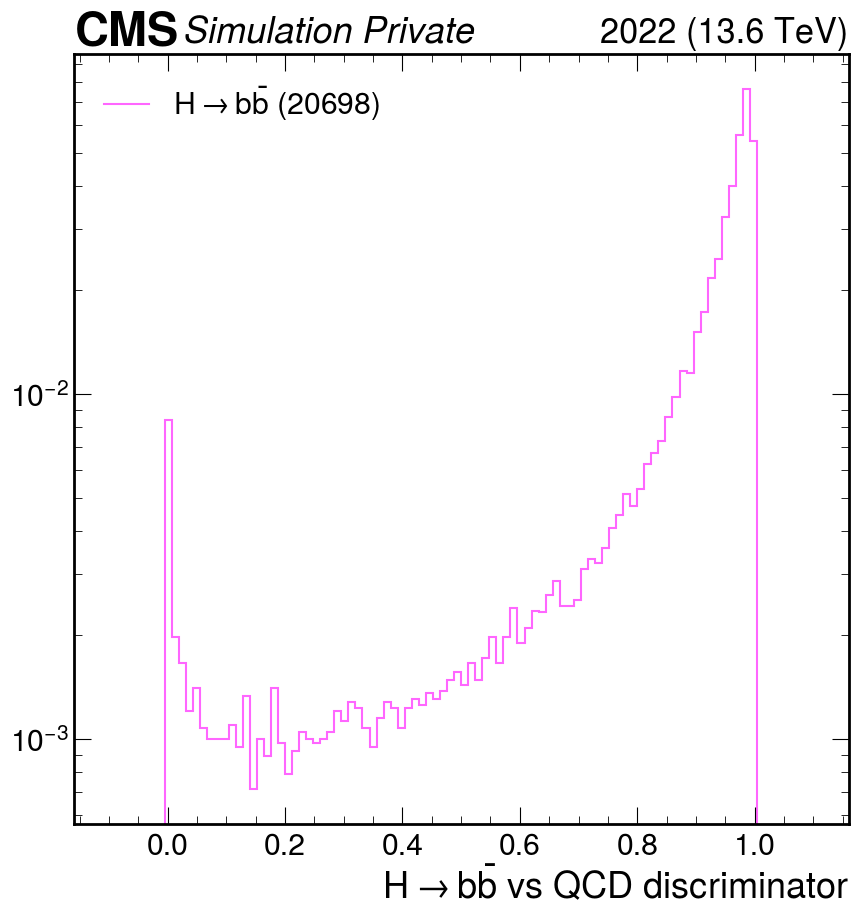

In [34]:
fig, ax = plt.subplots(figsize=(10,10))

h = output["h"]

h1 = h.project("disc1", "match")[:, hist.loc(1)]
n = h1.sum()
nf = h1.sum(flow=True)
h1 = h1 / nf
    
mplhep.histplot(h1, ax=ax, label=r"$H\rightarrow b\bar{b}$" + f" ({n:.0f})", color=colours["hbb"])
    
ax.set_yscale('log')
ax.legend(loc="best")
label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

/tmp/ipykernel_31/2785868794.py:73: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 12000) #400000


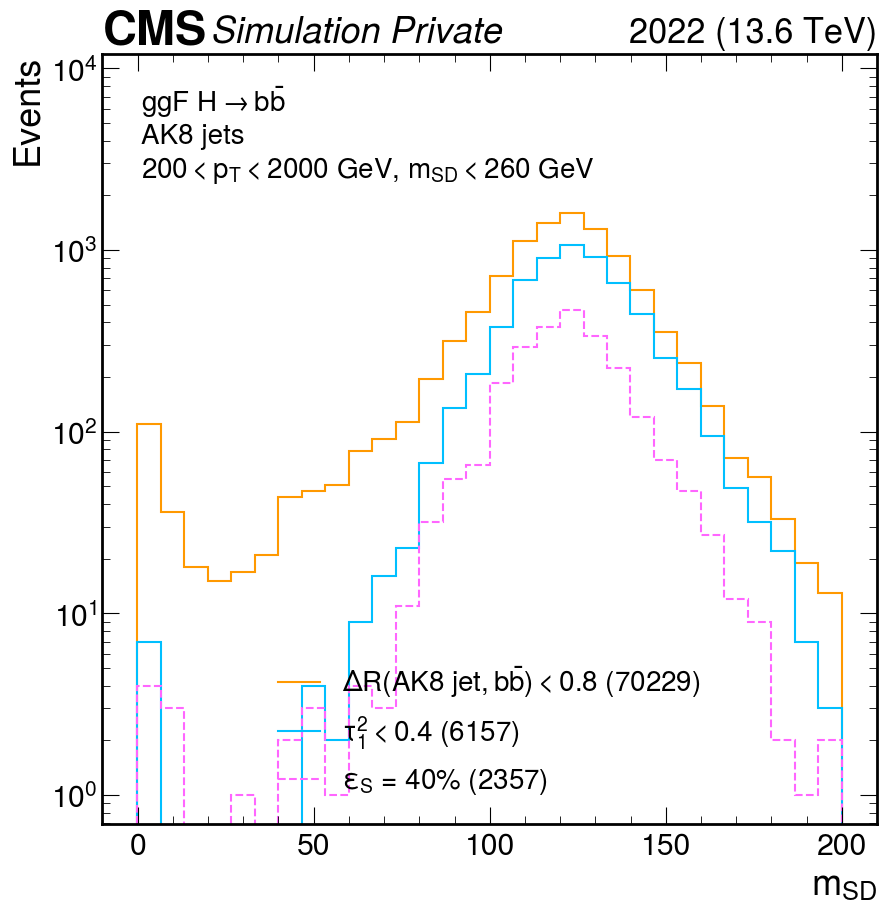

In [121]:
fig, ax = plt.subplots(figsize=(10,10))

colours = {
    "black" : "black",
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
    "hcc" : "deepskyblue",
    "hqq" : "limegreen",
}

h = output["h"]

# just the msd
# h1 = h.project("msd")
# n = h1.sum()
# # h1 = h1 / n
# mplhep.histplot(h1, ax=ax, label=r"Baseline" + f" ({n:.0f})", color=colours["qcd"])

# require match
h1_unmatch = h.project("msd", "match")[:, hist.loc(0)]
h1_match = h.project("msd", "match")[:, hist.loc(1)]
n_unmatch = h1_unmatch.sum()
n_match = h1_match.sum()
# h1 = h1 / n
# mplhep.histplot([h1_unmatch, h1_match],
#                 ax=ax, stack=True,
#                 label=[r"$\Delta R(H, b\bar{b}) > 0.8$" + f" ({n_unmatch:.0f})",
#                        r"$\Delta R(H, b\bar{b}) < 0.8$" + f" ({n_match:.0f})"],
#                 color=[colours["qcd"],
#                       colours["hbb"]])
mplhep.histplot([h1_match],
                ax=ax, stack=True,
                label=[r"$\Delta R(AK8~jet, b\bar{b}) < 0.8$" + f" ({n_unmatch:.0f})"],
                color=[colours["qcd"]])

# require tau21
h1 = h.project("msd", "match", "tau21")[:, hist.loc(1), hist.loc(0):hist.loc(0.4):sum]
n = h1.sum()
# h1 = h1 / n
mplhep.histplot(h1, ax=ax, label=r"$\tau^2_1 < 0.4$" + f" ({n:.0f})", color=colours["hcc"])

# h1 = h.project("msd", "match", "disc2")[:, hist.loc(1), 1:4:sum]
# n = h1.sum()
# # h1 = h1 / n
# mplhep.histplot(h1, ax=ax, label=r"$\epsilon_S$ = 80%" + f" ({n:.0f})", color=colours["hqq"], linestyle="--")

# h1 = h.project("msd", "match", "disc2")[:, hist.loc(1), 2:4:sum]
# n = h1.sum()
# # h1 = h1 / n
# mplhep.histplot(h1, ax=ax, label=r"$\epsilon_S$ = 60%" + f" ({n:.0f})", color=colours["hcc"], linestyle="--")

h1 = h.project("msd", "match", "disc2")[:, hist.loc(1), 3:4:sum]
n = h1.sum()
# h1 = h1 / n
mplhep.histplot(h1, ax=ax, label=r"$\epsilon_S$ = 40%" + f" ({n:.0f})", color=colours["hbb"], linestyle="--")

ax.set_yscale('log')
# ax.set_ylim(0, 400000)
ax.set_ylim(0, 12000) #400000
ax.legend(loc="lower center", fontsize=20)
ax.set_ylabel("Events")
label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.83, r"ggF $H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )

# fig.savefig("mSD.pdf", bbox_inches='tight', pad_inches=0.1)

In [153]:
h = output["h"]

results = {}

for label, match in [("Efficiency (%)", 1), ("Mistag rate (%)", 0)]:
    
    results[label] = {}
    
    for eff, wp in [(40, 3), (60, 2), (80, 1)]:
    
        h1 = h.project("msd", "match", "disc2")[:, hist.loc(match), wp:4:sum]
        n = h1.sum()
        results[label][eff] = (n / h.project("msd", "match")[:, hist.loc(match)].sum()) * 100

import pandas as pd

df = pd.DataFrame(data=results)
df.index = ["$\epsilon_S$ = 40 %", "$\epsilon_S$ = 60 %", "$\epsilon_S$ = 80 %"]
df

In [11]:
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema, ScoutingJMENanoAODSchema, BaseSchema
from coffea import processor, util
from collections import defaultdict

class Processor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        
        dataset = events.metadata['dataset']
        output = defaultdict()
        output["nevents"] = len(events)
        
        h = Hist(
            hist.axis.Variable([-0.1, 0.8167194, 0.95448214, 0.9864132, 1.1], name="disc", label=r"$H\rightarrow b\bar{b}$ vs QCD discriminator"),
            hist.axis.Regular(50, -3.2, 3.2, name="eta", label=r"$\eta$"),
            hist.axis.Regular(50, -3.5, 3.5, name="phi", label=r"$\phi$"),
#             hist.axis.Regular(50, 190, 1000, name="pt", label=r"$p_T$"),
            hist.axis.Regular(36, 200, 2000, name="pt", label=r"$p_T"),
            hist.axis.Boolean(name="match"),
        )
        
        def normalise(arr):
            return ak.to_numpy(ak.fill_none(arr, np.nan))

        def hbb_disc(sig, bkg):
            return ak.where((sig + bkg == 0), 0, sig / (sig + bkg))
        
        fatjets = events.ScoutingFatJet
        fatjets = fatjets[
            (fatjets.pt > 200) &
            (fatjets.pt < 2000) &
            (fatjets.msoftdrop < 260)
        ]
        fatjet = ak.firsts(fatjets)

        # get Higgs
        H = events.GenPart[
            (abs(events.GenPart.pdgId) == 25)
            & (events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy']))
        ]

        # get b quarks
        b_H = ak.flatten(H.children)

        b_H_dr = fatjet.delta_r(b_H)
        index_descend_b_H = ak.argsort(b_H_dr, axis=1, ascending=False)
        b_H_dr_descend = b_H_dr[index_descend_b_H]

        # is fatjet matched to b quarks?
        is_fatjet_b_H = ak.firsts(b_H_dr_descend, axis=1) < 0.8
        
        disc = hbb_disc(
            fatjet.particleNet_prob_Hbb,
            fatjet.particleNet_prob_QCD
        )

        h.fill(
            disc = normalise(disc),
            eta = normalise(fatjet.eta),
            phi = normalise(fatjet.phi),
            pt = normalise(fatjet.pt),
            match = normalise(is_fatjet_b_H),
        )
        
        output["h"] = h

        return output

    def postprocess(self, accumulator):
        pass

In [12]:
fileset = {}
with open(f"{json_dir}/GluGluHto2B.json") as fin:
    fileset = json.load(fin)

futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema=ScoutingNanoAODSchema,
)

output = futures_run(
    fileset,
    "Events",
    processor_instance=Processor()
)

util.save(output, "outfiles/2022/tagger/GluGluHto2B_kinematic.coffea")

Output()

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


In [8]:
output = util.load("outfiles/2022/tagger/GluGluHto2B_kinematic.coffea")

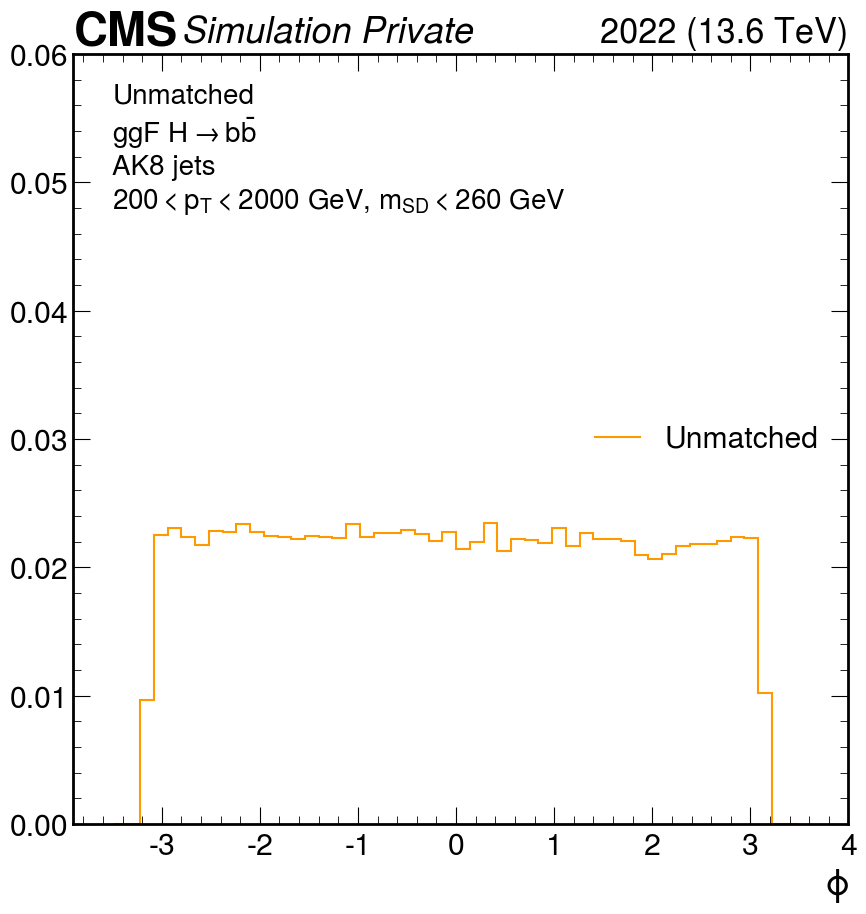

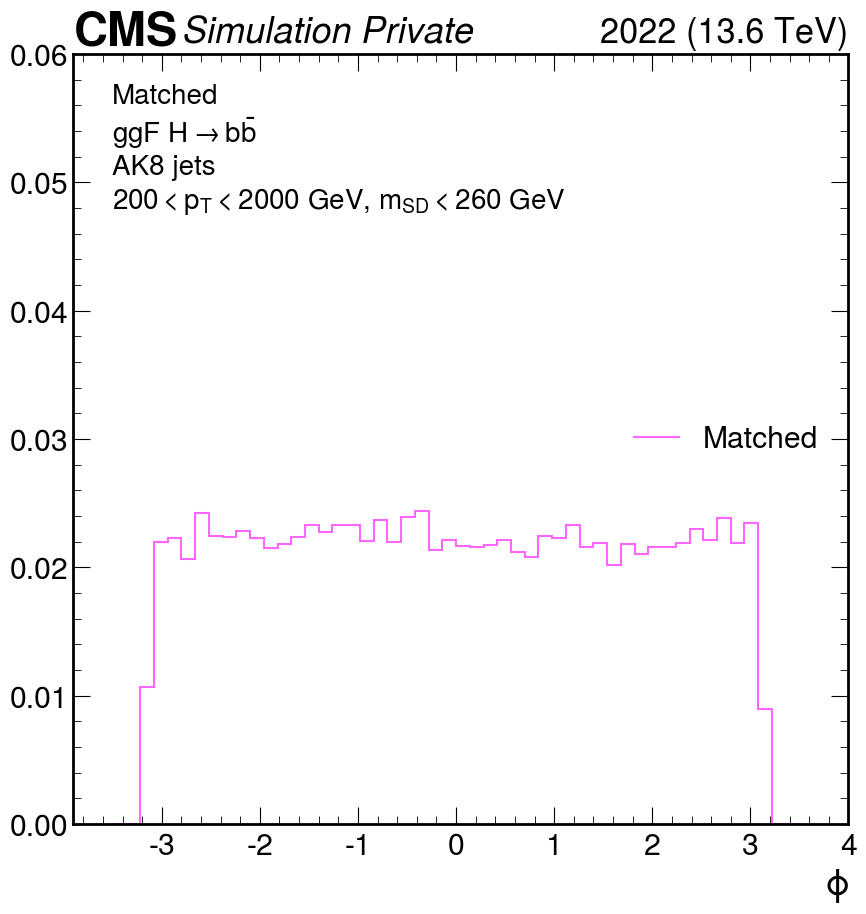

In [93]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

h = output["h"]

for events, match in [(f"Unmatched", 0), (f"Matched", 1)]:
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for var in ["phi"]:

        h1 = h.project(var, "match")[:, hist.loc(match)]
        h1 = h1 / h1.sum()

        mplhep.histplot(
            h1,
            ax=ax,
            label=events,
            color=colours["qcd"] if "Unmatched" in events else colours["hbb"],
       )

    
#     ax.set_yscale('log')
#     ax.set_xlabel(r"$m_{reco}$")
    ax.legend(loc="center right")
#     ax.legend(loc="lower center")
    if var == "eta":
        ax.set_ylim(0, 0.07)
        ax.set_xlim(-3.2, 4)
    elif var == "phi":
        ax.set_ylim(0, 0.06)
        ax.set_xlim(-3.9, 4)
    elif var == "pt":
        ax.set_ylim(0, 0.2)

    label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

    coffee = plt.text(0.05, 0.79, f"{events}\n" + r"ggF $H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                      fontsize=20,
                      horizontalalignment='left',
                      verticalalignment='bottom',
                      transform=ax.transAxes,
                     )
              
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

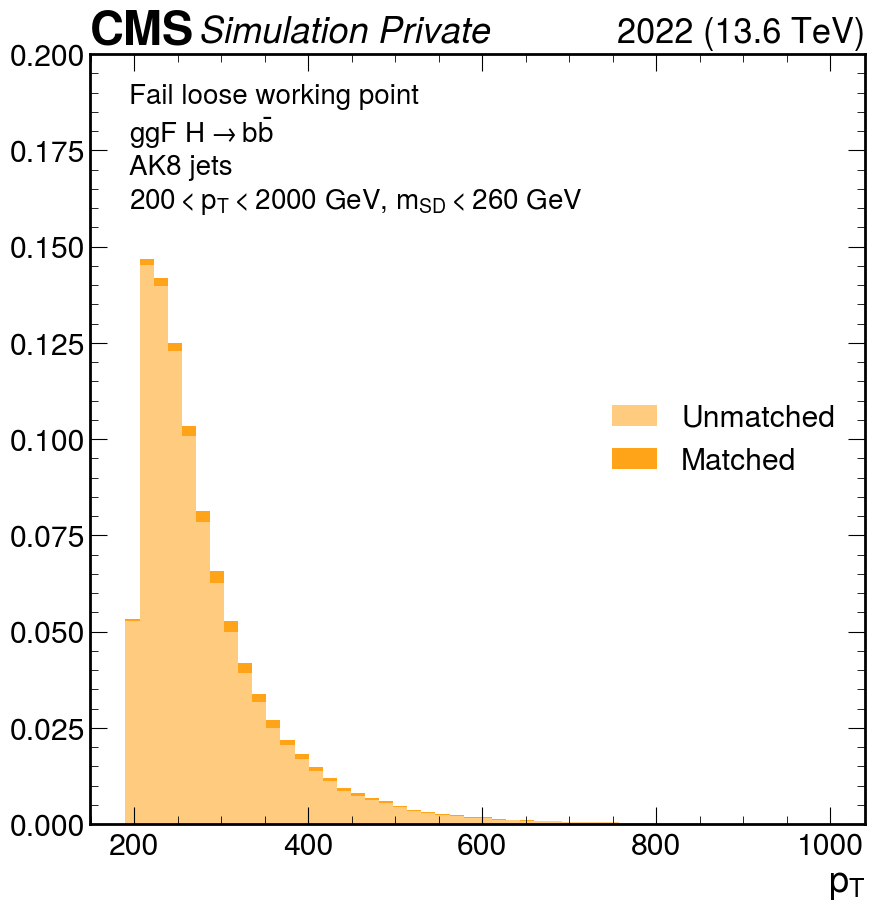

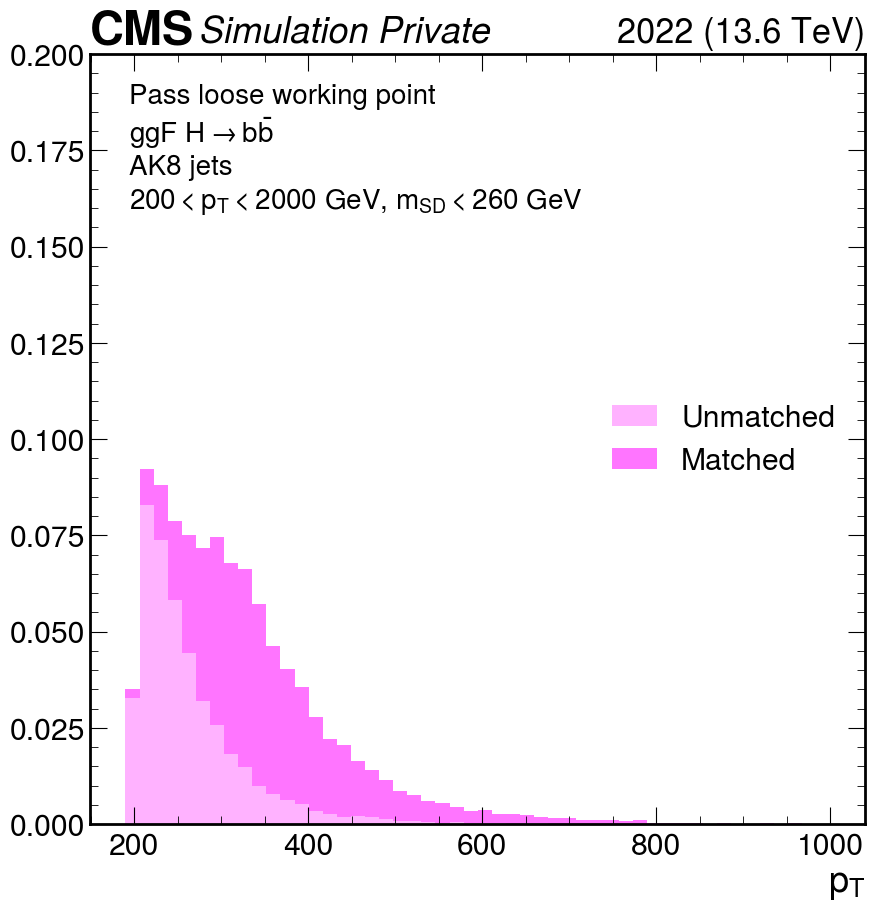

In [9]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 1

h = output["h"]

for events, match in [(f"Fail {labels[wp]} working point", 0), (f"Pass {labels[wp]} working point", 1)]:
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for var in ["pt"]:

        if "Pass" in events:
            h1 = h.project(var, "match", "disc")[:, :, wp:4:sum]
            h1 = h1 / h1.sum()
            h_match = h1[:, hist.loc(1)]
            h_unmatch = h1[:, hist.loc(0)]
        else:
            h1 = h.project(var, "match", "disc")[:, :, 0:wp:sum]
            h1 = h1 / h1.sum()
            h_match = h1[:, hist.loc(1)]
            h_unmatch = h1[:, hist.loc(0)]

        mplhep.histplot(
            [h_unmatch, h_match],
            ax=ax,
            stack=True,
            label=[f"Unmatched", f"Matched"],
            color=colours["hbb"] if "Pass" in events else colours["qcd"],
            edgecolor='k',
            alpha=[0.5, 0.9],
            histtype="fill"
       )

    
#     ax.set_yscale('log')
#     ax.set_xlabel(r"$m_{reco}$")
    ax.legend(loc="center right")
#     ax.legend(loc="lower center")
    if var == "eta":
        ax.set_ylim(0, 0.07)
        ax.set_xlim(-3.2, 4)
    elif var == "phi":
        ax.set_ylim(0, 0.06)
        ax.set_xlim(-3.9, 4)
    elif var == "pt":
        ax.set_ylim(0, 0.2)

    label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

    coffee = plt.text(0.05, 0.79, f"{events}\n" + r"ggF $H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                      fontsize=20,
                      horizontalalignment='left',
                      verticalalignment='bottom',
                      transform=ax.transAxes,
                     )
              
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

# QCD <a class="anchor" id="qcd"></a>

In [28]:
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema, ScoutingJMENanoAODSchema
from coffea import processor, util
from collections import defaultdict

from processors.helper import (
    add_pileup_weight,
)

class Processor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        
        dataset = events.metadata['dataset']
        output = defaultdict()
        
        h = Hist(
            hist.axis.Regular(30, -0.1, 1.1, name="disc1", label=r"$H\rightarrow b\bar{b}$ vs QCD discriminator"),
            hist.axis.Variable([-0.1, 0.8167194, 0.95448214, 0.9864132, 1.1], name="disc2", label=r"$H\rightarrow b\bar{b}$ vs QCD discriminator"),
            hist.axis.Regular(30, -0.1, 200, name="msd", label=r"$m_{SD}$"),
            hist.axis.Regular(30, -0.1, 1000, name="pt", label=r"$p_T$"),
        )
        
        def normalise(arr):
            return ak.to_numpy(ak.fill_none(arr, np.nan))

        def hbb_disc(sig, bkg):
            return ak.where((sig + bkg == 0), 0, sig / (sig + bkg))
        
        events = events[
            (events.Pileup.nPU < 100)
        ]
        
        output["nevents"] = len(events)
        
        add_pileup_weight(events)
        
        fatjets = events.ScoutingFatJet
        fatjets['weight_pileup'] = ak.broadcast_arrays(events['weight_pileup'], fatjets.pt)[0]
        fatjets = fatjets[
            (fatjets.pt > 200) &
            (fatjets.pt < 2000) &
            (fatjets.msoftdrop < 260)
        ]
        fatjet = ak.firsts(fatjets)
        
        disc = hbb_disc(
            fatjet.particleNet_prob_Hbb,
            fatjet.particleNet_prob_QCD
        )

        h.fill(
            disc1 = normalise(disc),
            disc2 = normalise(disc),
            msd = normalise(fatjet.msoftdrop),
            pt = normalise(fatjet.pt),
            weight = normalise(fatjet['weight_pileup']),
        )
        
        output["h"] = h

        return output

    def postprocess(self, accumulator):
        pass

In [29]:
fileset = {}
with open(f"{json_dir}/QCD_PT_15-7000_short.json") as fin:
    fileset = json.load(fin)
    
futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema=ScoutingNanoAODSchema,
)

output = futures_run(
    fileset,
    "Events",
    processor_instance=Processor()
)

util.save(output, "outfiles/2022/tagger/QCD_PT_15-7000_v2.coffea")

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


/tmp/ipykernel_30/2539517687.py:19: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**2)


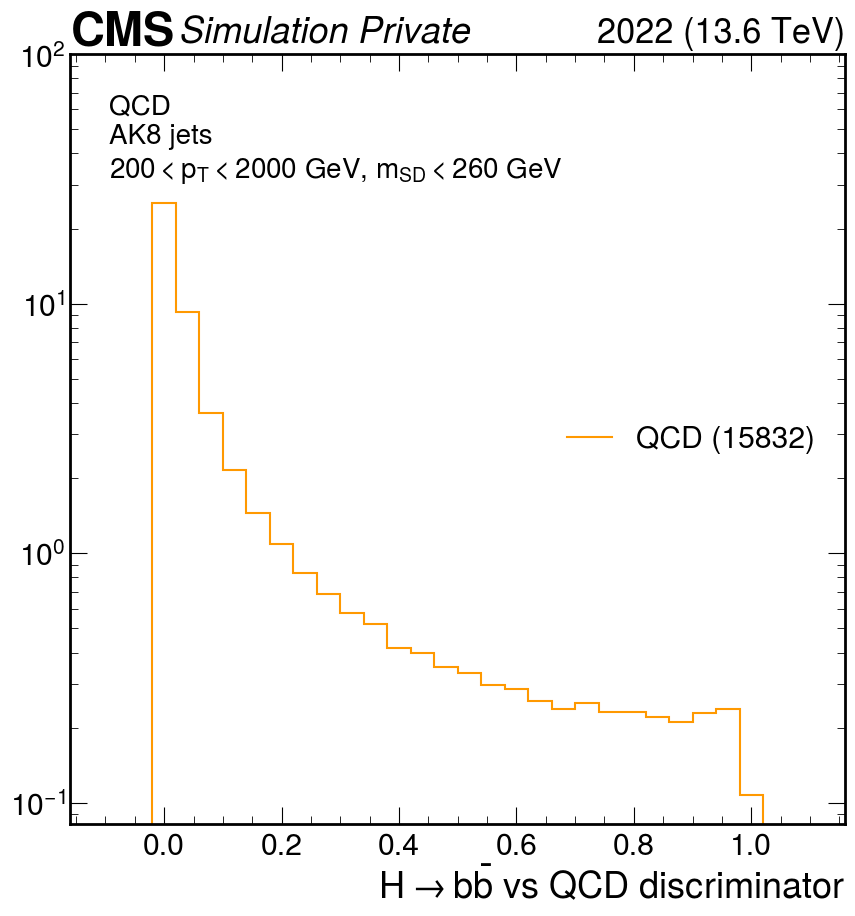

In [34]:
fig, ax = plt.subplots(figsize=(10,10))

colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900"
}

h = output["h"]

h1 = h.project("disc1")
# n = h1.sum()
h1 = h1 / n
    
mplhep.histplot(h1, ax=ax, label=f"QCD ({n:.0f})", color=colours["qcd"])
    
ax.set_yscale('log')
ax.legend(loc="center right")
label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")
ax.set_ylim(0, 10**2)

coffee = plt.text(0.05, 0.83, "QCD\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
#                   weight='bold'
                 )
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

/tmp/ipykernel_30/2203534352.py:36: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)


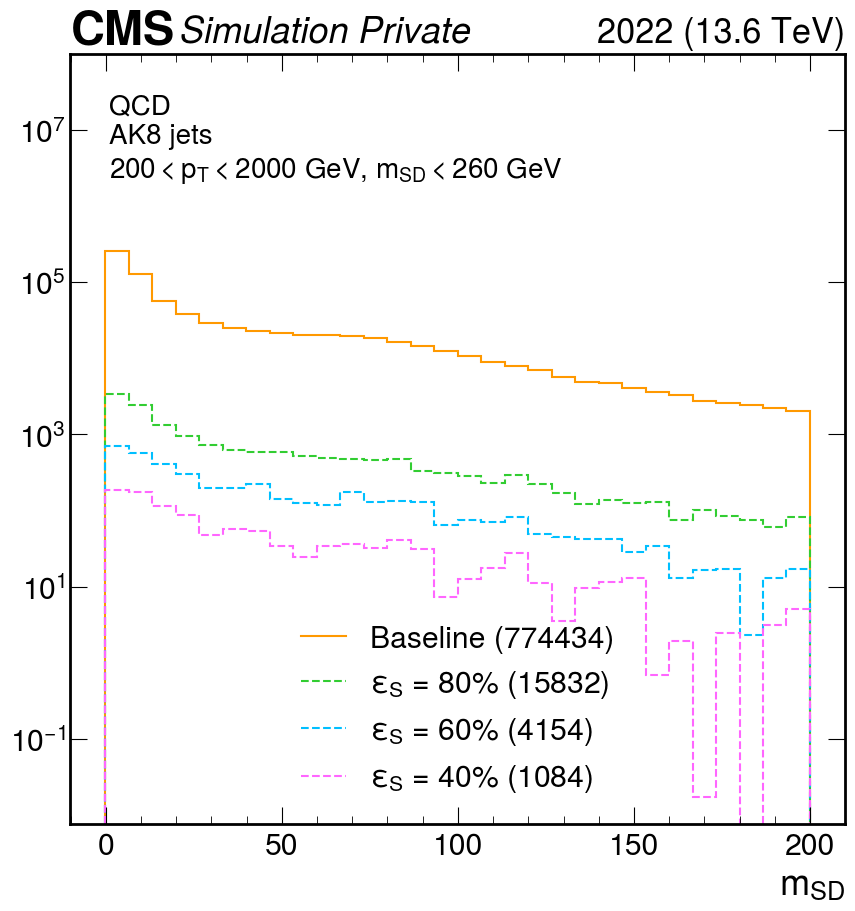

In [35]:
fig, ax = plt.subplots(figsize=(10,10))

colours = {
    "black" : "black",
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
    "hcc" : "deepskyblue",
    "hqq" : "limegreen",
}

h = output["h"]

h1 = h.project("msd")
n = h1.sum()
# h1 = h1 / n
mplhep.histplot(h1, ax=ax, label=r"Baseline" + f" ({n:.0f})", color=colours["qcd"])

h1 = h.project("msd", "disc2")[:, 1:4:sum]
n = h1.sum()
# h1 = h1 / n
mplhep.histplot(h1, ax=ax, label=r"$\epsilon_S$ = 80%" + f" ({n:.0f})", color=colours["hqq"], linestyle="--")

h1 = h.project("msd", "disc2")[:, 2:4:sum]
n = h1.sum()
# h1 = h1 / n
mplhep.histplot(h1, ax=ax, label=r"$\epsilon_S$ = 60%" + f" ({n:.0f})", color=colours["hcc"], linestyle="--")

h1 = h.project("msd", "disc2")[:, 3:4:sum]
n = h1.sum()
# h1 = h1 / n
mplhep.histplot(h1, ax=ax, label=r"$\epsilon_S$ = 40%" + f" ({n:.0f})", color=colours["hbb"], linestyle="--")
    
ax.set_yscale('log')
ax.legend(loc="lower center")
label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")
ax.set_ylim(0, 10**8)

coffee = plt.text(0.05, 0.83, "QCD\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )

# fig.savefig("mSD.pdf", bbox_inches='tight', pad_inches=0.1)

/tmp/ipykernel_30/3982741806.py:36: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)


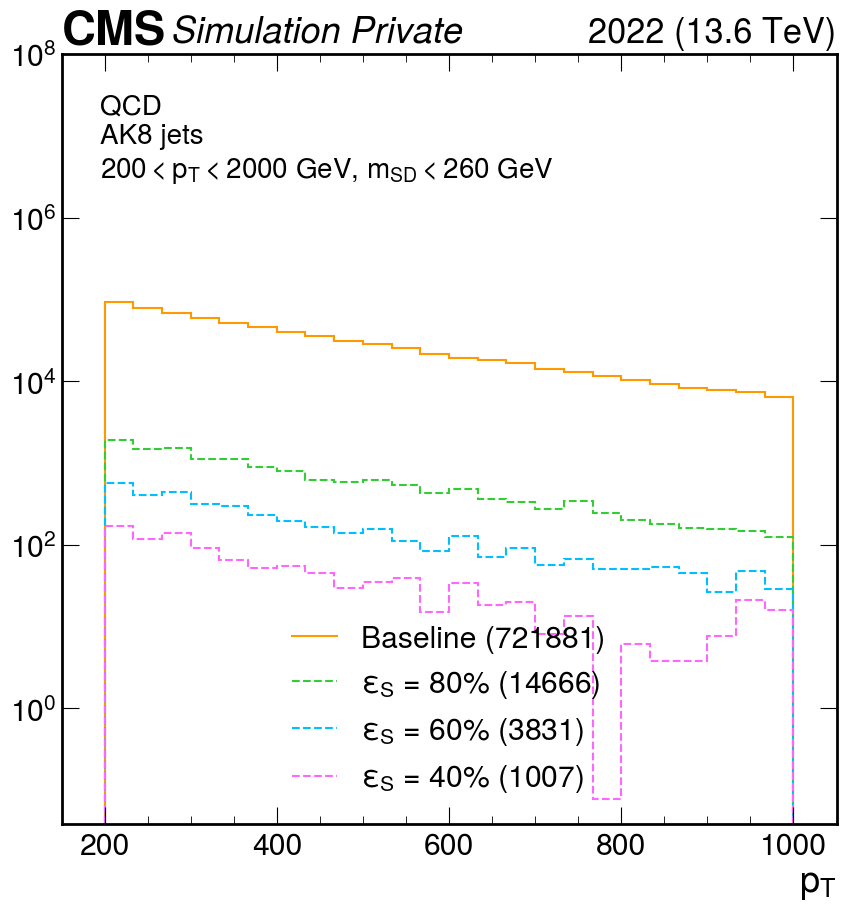

In [45]:
fig, ax = plt.subplots(figsize=(10,10))

colours = {
    "black" : "black",
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
    "hcc" : "deepskyblue",
    "hqq" : "limegreen",
}

h = output["h"]

h1 = h.project("pt")
n = h1.sum()
# h1 = h1 / n
mplhep.histplot(h1, ax=ax, label=r"Baseline" + f" ({n:.0f})", color=colours["qcd"])

h1 = h.project("pt", "disc2")[:, 1:4:sum]
n = h1.sum()
# h1 = h1 / n
mplhep.histplot(h1, ax=ax, label=r"$\epsilon_S$ = 80%" + f" ({n:.0f})", color=colours["hqq"], linestyle="--")

h1 = h.project("pt", "disc2")[:, 2:4:sum]
n = h1.sum()
# h1 = h1 / n
mplhep.histplot(h1, ax=ax, label=r"$\epsilon_S$ = 60%" + f" ({n:.0f})", color=colours["hcc"], linestyle="--")

h1 = h.project("pt", "disc2")[:, 3:4:sum]
n = h1.sum()
# h1 = h1 / n
mplhep.histplot(h1, ax=ax, label=r"$\epsilon_S$ = 40%" + f" ({n:.0f})", color=colours["hbb"], linestyle="--")
    
ax.set_yscale('log')
ax.legend(loc="lower center")
label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")
ax.set_ylim(0, 10**8)
ax.set_xlim(150, 1050)

coffee = plt.text(0.05, 0.83, "QCD\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )

# fig.savefig("pt.pdf", bbox_inches='tight', pad_inches=0.1)

In [36]:
h = output["h"]

results = {}

for label, match in [("Efficiency (%)", 1), ("Mistag rate (%)", 0)]:
    
    results[label] = {}
    
    for eff, wp in [(40, 3), (60, 2), (80, 1)]:
    
        if "Efficiency" in label:
            h1 = h.project("msd", "disc2")[:, 0:wp:sum]
        else:
            h1 = h.project("msd", "disc2")[:, wp:4:sum]
        n = h1.sum()
        results[label][eff] = (n / h.project("msd").sum()) * 100

In [37]:
import pandas as pd

df = pd.DataFrame(data=results)
df.index = ["$\epsilon_S$ = 40 %", "$\epsilon_S$ = 60 %", "$\epsilon_S$ = 80 %"]
df

,Efficiency (%),Mistag rate (%)
$\epsilon_S$ = 40 %,99.859972,0.140028
$\epsilon_S$ = 60 %,99.463647,0.536353
$\epsilon_S$ = 80 %,97.955610,2.044390
